In [1]:
# REBECCA2 (Reduced Effort Biologic ElectroChemical Cycling Analysis v2)
# Author: Chris Eschler, 2024
# Based on REBECCA code by Venkatesh Krishnamurthy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import sys
import re
import navani.echem as ec

os.makedirs('plots', exist_ok=True) # Dir to store plots
os.makedirs('outputs', exist_ok=True) # Dir to store other outputs

In [4]:
def append_import_to_df(df, filename, offset_flags=''):
    """
    Add the contents of a file to an existing DataFrame, possibly offsetting the time and capacity in the new data.
    The offsets will be based on the max time and latest capacity in the existing DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame to be added to.
        filename: The filepath that should be imported and added to the DataFrame.
        offset_flags: String containing T and/or C to indicate that time and/or capacity should be offset.
    """
    time_offset = 0
    capacity_offset = 0

    if 't' in offset_flags.lower():
        time_offset = df['time/s'].max()
    
    if 'c' in offset_flags.lower():
        df = df.sort_values(by='time/s', ignore_index=True)
        capacity_offset = df['Q charge/discharge/mA.h'].iloc[-1]

    new_data = ec.multi_file_biologic(filename, time_offset=time_offset, capacity_offset=capacity_offset)
    df = pd.concat([df, new_data], ignore_index=True)
    return df

In [5]:
print("Running in", os.getcwd())

# Import data files from the working directory amenable to analysis with this script
data_filenames = []
df = pd.DataFrame()
mpr_regex = r'(_\d{2}_[a-zA-Z]+)?_C\d{2}.mpr'

# If stitch.txt is present, use it to decide which files to import and their order.
# Groups of filenames separated by the line '&' in stitch.txt will be treated as part of the same test
# and will be joined without alterinre.sub(r'(_\d{2}_GCPL)?_C\d{2}.mpr', '.mps', data_filenames[0])g their time stamps.
# For example, if a test has two GCPL steps, it will produce separate files but with the same time sequencing.
if os.path.isfile('stitch.txt'):
    try:
        with open('stitch.txt', 'r') as file:
            lines = file.readlines()
            # If stitch.txt is empty, skip analysis
            if lines == []:
                print("Analysis skipped due to empty stitch.txt.")
                sys.exit(1)
            else:
                for line in lines:
                    # Separate each line by whitespace into the filename and the flags for which fields to offset (i.e. T for time and C for capacity)
                    line = line.strip().split(None, maxsplit=1)
                    filename = line[0]
                    if len(line) > 1:
                        offset_flags = line[1]
                    else:
                        offset_flags = ''

                    # If the filename does not correspond to a valid file, prompt the user to continue without it                        
                    if not os.path.isfile(filename):
                        inp = input(f"File {filename} from stitch.txt could not be found. Enter 'y' if you wish to skip it and continue anyway.")
                        if inp.lower() == 'y':
                            print(f"File {filename} skipped. Analysis continuing.")
                        else:
                            print("Analysis terminated by user.")
                            sys.exit(1)
                    # If the filename is already in data_filenames, prompt the user to continue
                    elif filename in data_filenames:
                        inp = input(f"Filename {filename} is duplicated in stitch.txt. Enter 'y' if you wish for it to be duplicated in the analysis. Otherwise, the repeat instance will be ignored.")
                        if inp.lower() == 'y':
                            df = append_import_to_df(df, filename, offset_flags=offset_flags)
                            data_filenames += [filename]
                    # Else filename corresponds to a filename that is not already in data_filenames
                    else:
                        df = append_import_to_df(df, filename, offset_flags=offset_flags)
                        data_filenames += [filename]
                print("Imported using stitch.txt.")
                mps_filenames = [re.sub(mpr_regex, '.mps', filename) for filename in data_filenames]
    except IOError:
        # If stitch.txt cannot be opened
        print("Unable to open/read stitch.txt. Analysis skipped.")
        sys.exit(1)

# If stitch.txt is not present, find files with certain keywords
# It is expected that all of the files found by this method belong to the same test (not a restarted test)
# Otherwise, stitch.txt should be used to explicitly indicate a restarted test
else:
    # Keyword expected to be in each filename to be analyzed (if there are multiple .mpr files)
    search_keyword = '_GCPL_'
    match_string = '*'+search_keyword+'*.mpr'
    data_filenames += glob.glob(match_string)
    # # Order files by time of creation so that they get added in sequence to the dataframe
    # data_filenames.sort(key=os.path.getctime)

    # Check whether no matches with search_keyword were found
    if len(data_filenames) == 0:
        # If only one .mpr file was made by the test, it should be used even if it lacks the search_keyword
        data_filenames += glob.glob('*.mpr')
        if len(data_filenames) == 0:
            print("No .mpr files found by auto-search.")
            sys.exit(1)
        elif len(data_filenames) > 1:
            print("Too many .mpr files found by auto-search. Use stitch.txt to indicate which files to analyze.")
            sys.exit(1)

    # All the files to be analyzed should be part of the same test, i.e. share a .mps file
    # Otherwise stitch.txt should be used
    # Back-generate the .mps filename that would create each file and check that they are the same
    mps_filenames = [re.sub(mpr_regex, '.mps', filename) for filename in data_filenames]
    if len(set(mps_filenames)) > 1:
        print("Auto-search found files from multiple tests. Use stitch.txt to indicate which files to analyze.")
        sys.exit(1)

    for filename in data_filenames:
        df = append_import_to_df(df, filename)

print(f"Data file(s): {data_filenames}")

# Assume that the cell characteristics are the same in all settings files, only look at settings file associated with first data file
settings_filename = mps_filenames[0]
print(f"Settings file: {settings_filename}")
try:
    with open(settings_filename, 'r') as file:
        # Iterate through settings file to fill in active material mass and other cell parameters
        i = 0
        while True:
            i += 1
            line = file.readline()

            if not line:
                break

            # TODO: refactor to decrease repetition and raise exceptions when variables aren't defined
            elif line.startswith("Mass of active material"):
                match = re.search(r"\d+\.\d*", line)
                active_material_mass = match.group(0)
                print(f"Active material mass = {active_material_mass}")

            elif line.startswith(" at x = "):
                match = re.search(r"\d+\.\d*", line)
                mass_at_x = match.group(0)
                print(f"At x = {mass_at_x}")

            elif line.startswith("Molecular weight of active material"):
                match = re.search(r"\d+\.\d*", line)
                mol_weight = match.group(0)
                print(f"Molecular weight = {mol_weight}")

            elif line.startswith("Atomic weight of intercalated ion"):
                match = re.search(r"\d+\.\d*", line)
                interc_weight = match.group(0)
                print(f"Intercalated ion weight = {interc_weight}")

            elif line.startswith("Acquisition started at"):
                match = re.search(r"\d+\.\d*", line)
                starting_x = match.group(0)
                print(f"Acquisition started at {starting_x}")

            elif line.startswith("Number of e- transfered per intercalated ion"):
                match = re.search(r"\d+", line)
                e_per_ion = match.group(0)
                print(f"e per ion = {e_per_ion}")

            elif line.startswith("Electrode surface area"):
                match = re.search(r"\d+\.?\d*", line)
                surface_area = match.group(0)
                print(f"Surface area = {surface_area}")        
except:
    print("Unable to open settings file.")

# Post-processing
df = df.sort_values(by='time/s', ignore_index=True)
df = ec.biologic_processing(df)
df = ec.df_post_process(df)
print(df)

# Export navani-processed dataframe as a .csv for later use
# Path for .csv with same filename as .mps, based on .mpr
data_csv_filename = os.path.join('outputs', settings_filename.replace('.mps', '.csv'))
df.to_csv(data_csv_filename)
print(f"CSV exported to: {data_csv_filename}")

Running in /home/eschlerc/Dropbox (MIT)/MIT/_Grad/Thesis/Data/navani_analysis
Data file(s): ['240703-CC040A-2cyc_C100_1V_4p5V_GITT_6h_10SoC-RT_04_GCPL_C01.mpr']
Settings file: 240703-CC040A-2cyc_C100_1V_4p5V_GITT_6h_10SoC-RT.mps
Active material mass = 4.240
At x = 0.000
Molecular weight = 101.540
Intercalated ion weight = 6.940
Acquisition started at 0.000
e per ion = 2
Surface area = 2.011
         flags  Ns        time/s  dQ/mA.h   (Q-Qo)/mA.h  control/V/mA  \
0           23   0  2.278052e+04      0.0 -3.619216e-09      3.130296   
1           23   0  2.278152e+04      0.0 -3.619216e-09      0.000000   
2           23   0  2.278252e+04      0.0 -3.619216e-09      0.000000   
3           23   0  2.278352e+04      0.0 -3.619216e-09      0.000000   
4           23   0  2.278452e+04      0.0 -3.619216e-09      0.000000   
...        ...  ..           ...      ...           ...           ...   
1041451      7   4  1.716399e+06      0.0 -8.537249e-01      0.000000   
1041452      7   4  1.

In [6]:
# Generate cycle summary data and export to another .csv
cycle_summary = ec.cycle_summary(df)
cycle_summary_csv_filename = os.path.join('outputs', 'cycle_summary.csv')
cycle_summary.to_csv(cycle_summary_csv_filename)
print(f"Cycle summary CSV exported to: {cycle_summary_csv_filename}")
print(cycle_summary)

Cycle summary CSV exported to: outputs/cycle_summary.csv
             Current       UCV       LCV  Discharge Capacity  Charge Capacity  \
full cycle                                                                      
0.0        -0.021012  3.142920  1.117564            2.240000              NaN   
1.0         0.001085  4.500118  0.999770            1.525725         1.695091   
2.0         0.021247  3.759671  1.249127                 NaN         0.672000   

                  CE  Discharge Energy  Charge Energy  \
full cycle                                              
0.0              NaN          5.253512            NaN   
1.0         0.900085          2.792070       5.975868   
2.0              NaN               NaN       1.960645   

            Average Discharge Voltage  Average Charge Voltage  
full cycle                                                     
0.0                          2.345318                     NaN  
1.0                          1.829995                3.5253

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Capacity / mAh', ylabel='Voltage / V'>)

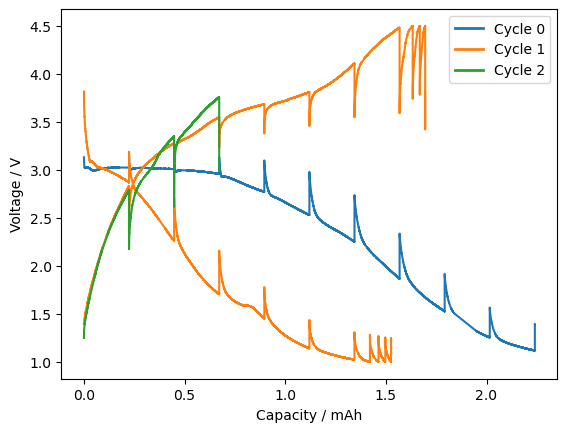

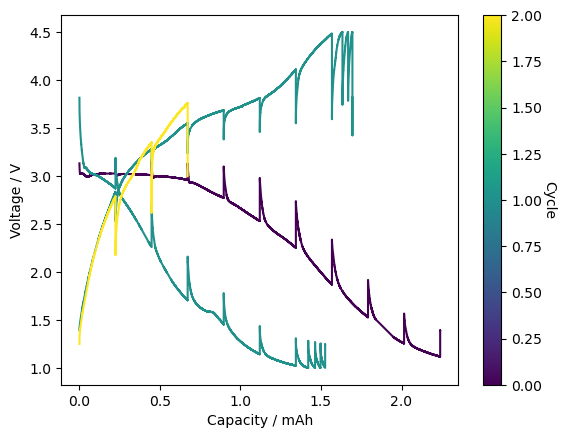

In [7]:
ec.charge_discharge_plot(df, [0,1,2])
ec.multi_cycle_plot(df, [0,1,2])

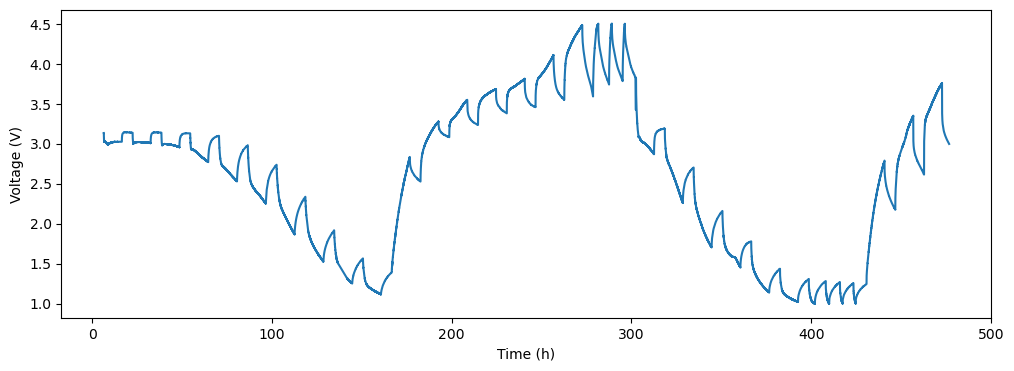

In [8]:
plt.figure(figsize=(12,4))
plt.plot(df['Time']/3600, df['Voltage'], '-')
# plt.ylim([2.5, 3.5])
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
# plt.savefig('plots/voltage_time_series.png')
plt.show()

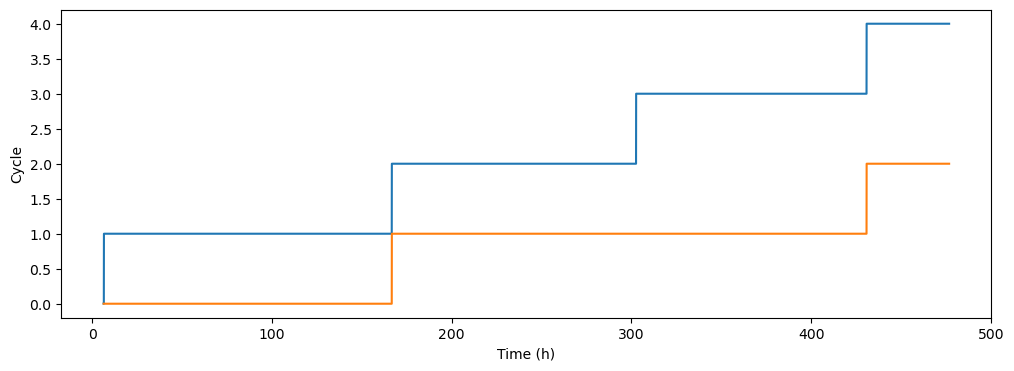

In [9]:
plt.figure(figsize=(12,4))
plt.plot(df['Time']/3600, df['half cycle'], '-')
plt.plot(df['Time']/3600, df['full cycle'], '-')
# plt.ylim([2.5, 3.5])
plt.xlabel('Time (h)')
plt.ylabel('Cycle')
# plt.savefig('plots/voltage_time_series.png')
plt.show()